# **Spam Email Filtering using PyTorch**

In [ ]:
#Rajavardhan Reddy Gogulamudi

## **Step 1: Import Required Libraries**

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical computations
import pandas as pd  # For handling tabular data
import torch  # PyTorch framework for deep learning
import torch.nn as nn  # PyTorch neural network module
from torch.utils.data import Dataset, DataLoader  # Utilities for dataset handling
from sklearn.model_selection import train_test_split  # Splitting dataset into train and test sets
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.linear_model import LogisticRegression  # Logistic Regression from Scikit-learn
from sklearn.metrics import accuracy_score  # To calculate model accuracy
import os  # For handling file operations

## **Step 2: Load the Dataset**

In [ ]:
# The dataset is a CSV file with 57 features and 1 label (spam = 1, not spam = 0)
data = pd.read_csv("spambase.data", header=None)  # No header in dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## **Step 3: Data Preprocessing**

In [ ]:
# Separate features (X) and target labels (y)
X = data.iloc[:, :-1].values  # First 57 columns as features;
y = data.iloc[:, -1].values   # Last column as target (1 = spam, 0 = not spam)

# ℹ️ Why?
# Features (X) are the email attributes, and y is the label (spam or not).
# We need to train the model to predict y from X.

## **Step 4: Train Test Split**

In [ ]:
# Split the dataset into training (70%) and testing (30%) sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ℹ️ Why?
# We split the dataset into 70% training and 30% testing data.
# Training data is used to train the model; test data is used to evaluate its performance.

## **Step 5: Normalization**

In [ ]:
# Normalize the features using z-score normalization
mean = x_train.mean(axis=0)  # Calculate mean of training data
std = x_train.std(axis=0)  # Calculate standard deviation of training data
x_train = (x_train - mean) / std  # Normalize training data
x_test = (x_test - mean) / std  # Normalize test data using training mean and std


# ℹ️ Why?
# Normalization ensures that features are on the same scale.
# This speeds up training and avoids one feature dominating due to larger values.

## **Step 6: Convert to PyTorch Senors**

In [ ]:
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape to (n_samples, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ℹ️ Why?
# PyTorch models work with tensors. Also, y is reshaped to (N, 1) for compatibility with the model output.

## **Step 7: Define a Custom Dataset Class**

In [ ]:
# Define a custom PyTorch dataset class
class SpambaseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # Store feature data
        self.labels = labels  # Store target labels

    def __len__(self):
        return len(self.data)  # Return total number of samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]  # Return one sample at index idx

# ℹ️ Why?
# This allows us to use DataLoader to efficiently load data in batches during training.

## **Step 8: Create Dataloaders**

In [ ]:
# Create dataset objects and dataloaders for batch processing
batch_size = 64  # Define batch size
train_dataset = SpambaseDataset(X_train_tensor, y_train_tensor)  # Create training dataset
test_dataset = SpambaseDataset(X_test_tensor, y_test_tensor)  # Create testing dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Load training data in batches
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Load test data in batches

# ℹ️ Why?
# Dataloaders help efficiently feed data in mini-batches for training (better memory usage, faster convergence).

## **Step 9: Define Logistic Regression Model**

In [ ]:
# Define the Logistic Regression model using PyTorch
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Linear layer with one output (for binary classification)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Apply sigmoid activation to output probabilities

# ℹ️ Why?
# Logistic regression is a linear model where we apply sigmoid activation to predict probabilities between 0 and 1.

## **Step 10: Model Initialization**

In [ ]:
# Initialize model, loss function, and optimizer
input_size = X_train_tensor.shape[1]  # Number of input features
model = LogisticRegressionModel(input_size)  # Create model instance
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss (for binary classification)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

## **Step 11: Define Training and Evaluation Functions**

In [ ]:
# Function for training the model
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set model to training mode
    total_loss = 0  # Track total loss
    for batch, (X, y) in enumerate(dataloader):  # Iterate through batches
        optimizer.zero_grad()  # Reset gradients
        y_pred = model(X)  # Forward pass (predict output)
        loss = loss_fn(y_pred, y)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate loss
    return total_loss / len(dataloader)  # Return average loss

# Function for evaluating the model on test data
def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    total_loss = 0  # Track total loss
    correct = 0  # Track number of correct predictions
    with torch.no_grad():  # Disable gradient computation for evaluation
        for X, y in dataloader:  # Iterate through test batches
            y_pred = model(X)  # Get model predictions
            total_loss += loss_fn(y_pred, y).item()  # Compute loss
            correct += ((y_pred > 0.5).int() == y.int()).sum().item()  # Count correct predictions
    accuracy = correct / len(dataloader.dataset)  # Compute accuracy
    return total_loss / len(dataloader), accuracy  # Return loss and accuracy


# ℹ️ Why?
# `train_loop` trains the model using backpropagation.
# `test_loop` evaluates performance without updating weights.

## **Step 12: Train and Evaluate the Model**

In [ ]:
# Train and evaluate the model
epochs = 100  # Number of training epochs
train_losses = []  # List to store training losses
test_losses = []  # List to store test losses
test_accuracies = []  # List to store test accuracy

for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)  # Train model for one epoch
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)  # Evaluate model on test data
    train_losses.append(train_loss)  # Store training loss
    test_losses.append(test_loss)  # Store test loss
    test_accuracies.append(test_accuracy)  # Store test accuracy
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Test Accuracy={test_accuracy*100:.2f}%")

Epoch 1: Train Loss=0.6735, Test Loss=0.5923, Test Accuracy=75.60%
Epoch 2: Train Loss=0.5246, Test Loss=0.5001, Test Accuracy=83.06%
Epoch 3: Train Loss=0.4539, Test Loss=0.4511, Test Accuracy=84.72%
Epoch 4: Train Loss=0.4134, Test Loss=0.4204, Test Accuracy=86.53%
Epoch 5: Train Loss=0.3856, Test Loss=0.3988, Test Accuracy=87.11%
Epoch 6: Train Loss=0.3667, Test Loss=0.3829, Test Accuracy=87.47%
Epoch 7: Train Loss=0.3512, Test Loss=0.3704, Test Accuracy=87.98%
Epoch 8: Train Loss=0.3394, Test Loss=0.3605, Test Accuracy=88.49%
Epoch 9: Train Loss=0.3310, Test Loss=0.3521, Test Accuracy=88.92%
Epoch 10: Train Loss=0.3237, Test Loss=0.3452, Test Accuracy=89.14%
Epoch 11: Train Loss=0.3167, Test Loss=0.3393, Test Accuracy=89.36%
Epoch 12: Train Loss=0.3108, Test Loss=0.3342, Test Accuracy=89.28%
Epoch 13: Train Loss=0.3048, Test Loss=0.3299, Test Accuracy=89.43%
Epoch 14: Train Loss=0.3010, Test Loss=0.3260, Test Accuracy=89.65%
Epoch 15: Train Loss=0.2991, Test Loss=0.3226, Test Accur

## **Step 13: Compare with Scikit-learn Logistic Regression**

In [ ]:
# Compare with Scikit-learn Logistic Regression
lr_model = LogisticRegression(max_iter=1000)  # Create Scikit-learn logistic regression model
lr_model.fit(x_train, y_train)  # Train Scikit-learn model
y_pred = lr_model.predict(x_test)  # Predict on test data
sklearn_accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy
print(f"Scikit-learn Logistic Regression Accuracy: {sklearn_accuracy*100:.2f}%")

Scikit-learn Logistic Regression Accuracy: 90.88%


## **Step 14: Plot Training and Testing Loss**

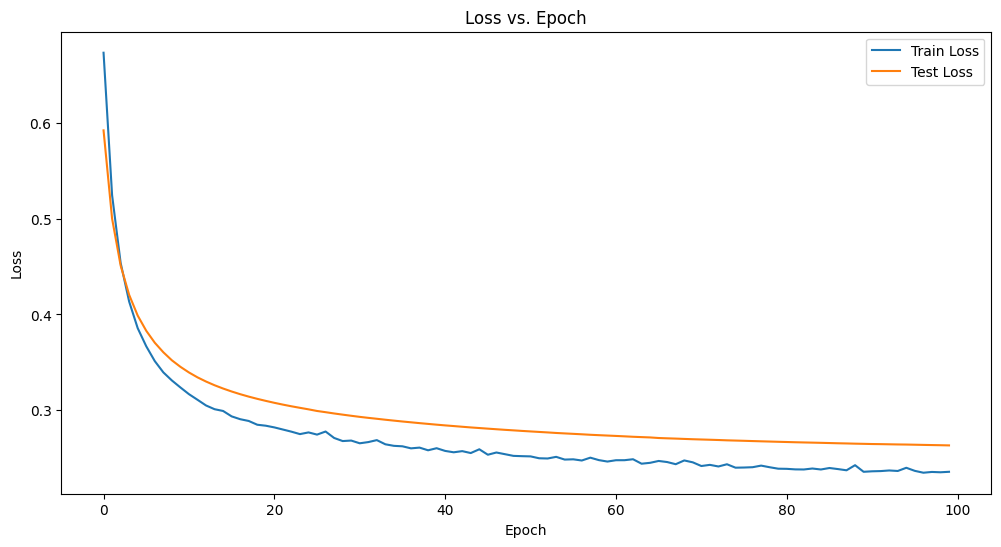

In [ ]:
# Plot training and test losses over epochs
plt.figure(figsize=(12, 6))  # Define figure size
plt.plot(train_losses, label="Train Loss")  # Plot training loss
plt.plot(test_losses, label="Test Loss")  # Plot test loss
plt.xlabel("Epoch")  # Label x-axis
plt.ylabel("Loss")  # Label y-axis
plt.title("Loss vs. Epoch")  # Title of the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

## **Step 15: Plot Accuracy**

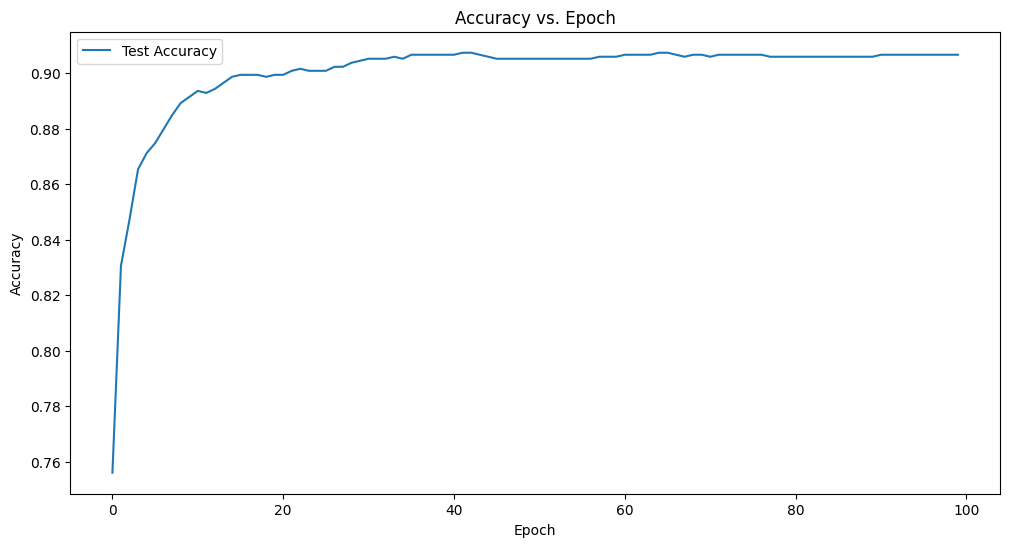

In [ ]:
# Plot test accuracy over epochs
plt.figure(figsize=(12, 6))  # Define figure size
plt.plot(test_accuracies, label="Test Accuracy")  # Plot test accuracy
plt.xlabel("Epoch")  # Label x-axis
plt.ylabel("Accuracy")  # Label y-axis
plt.title("Accuracy vs. Epoch")  # Title of the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

# ℹ️ Why?
# Visualizing loss and accuracy helps understand training behavior and check for underfitting/overfitting.

## **Step 16: Plot Predicted Probabilities (Spam vs Legitimate)**

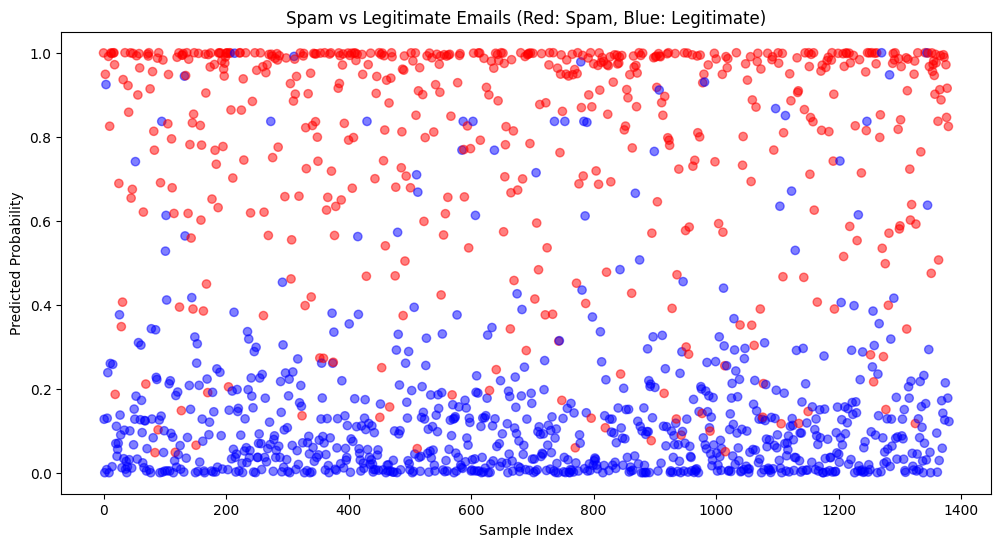

In [ ]:
# Visualize classification of spam vs. legitimate emails
preds = model(X_test_tensor).detach().numpy()  # Get model predictions for test data
plt.figure(figsize=(12, 6))  # Define figure size
plt.scatter(range(len(preds)), preds, c=["red" if label == 1 else "blue" for label in y_test], alpha=0.5)  # Scatter plot with colors
plt.title("Spam vs Legitimate Emails (Red: Spam, Blue: Legitimate)")  # Title
plt.ylabel("Predicted Probability")  # Label y-axis
plt.xlabel("Sample Index")  # Label x-axis
plt.show()  # Show the plot